In [1]:
%matplotlib inline

from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
wk_dir = os.getcwd()
data_dir = wk_dir + "/../../data/kg/cd-redux/sample/"

In [3]:
model_dir = data_dir + "/models/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [5]:
trn_batches = get_batches(data_dir + "/train/", shuffle=False, batch_size=1)
val_batches = get_batches(data_dir + "/valid/", shuffle=False, batch_size=1)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
trn_data = get_data(data_dir + "/train/")
val_data = get_data(data_dir + "/valid/")

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Okay, what's going on here? We have training and validation *batches*, as well as training and validation *data*. 

Neither `get_batches` nor `get_data` has a docstring, so we can try to look at the source code for each function:

```
def get_data(path, target_size=(224,224)):
    batches = get_batches(
        path, 
        shuffle=False, 
        batch_size=1, 
        class_mode=None, 
        target_size=target_size
    )
    return np.concatenate(
        [batches.next() for i in range(batches.nb_sample)]
    )
    
def get_batches(
        dirname, 
        gen=image.ImageDataGenerator(), 
        shuffle=True, 
        batch_size=4, 
        class_mode='categorical',
        target_size=(224,224)
    ):
    return gen.flow_from_directory(
        dirname, 
        target_size=target_size,
        class_mode=class_mode, 
        shuffle=shuffle, 
        batch_size=batch_size
    )
```

It looks like the key difference is that `get_batches` uses `image.ImageDataGenerator()`, and I believe a `get_batches` returns a collection of images, whereas `get_data` returns the image data in a numerical format.

We can test this by trying to look at each data type:

In [7]:
type(trn_batches)

keras.preprocessing.image.DirectoryIterator

In [8]:
type(trn_data)

numpy.ndarray

`trn_batch` is a DirectoryIterator object (whatever that means), and `trn_data` is a NumPy array.

Trying to access the first item in `trn_data` gives us:

In [9]:
trn_data[0]

array([[[ 112.,  119.,  128., ...,  128.,  127.,  127.],
        [ 119.,  128.,  136., ...,  133.,  127.,  127.],
        [ 127.,  136.,  144., ...,  141.,  127.,  127.],
        ..., 
        [ 123.,  128.,  132., ...,  136.,  127.,  127.],
        [ 120.,  125.,  132., ...,  135.,  127.,  127.],
        [ 127.,  127.,  127., ...,  127.,  127.,  127.]],

       [[   3.,    2.,    3., ...,    6.,    0.,    0.],
        [   2.,    0.,    1., ...,    2.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ..., 
        [   4.,    2.,    0., ...,    0.,    0.,    0.],
        [   4.,    2.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[ 255.,  255.,  245., ...,  241.,  255.,  255.],
        [ 255.,  255.,  251., ...,  244.,  255.,  255.],
        [ 255.,  255.,  255., ...,  253.,  255.,  255.],
        ..., 
        [ 254.,  252.,  249., ...,  255.,  255.,  255.],
        [ 255.,  255.,  252., ...,  236., 

If we tried to access `trn_batches` in the same way, we would get an error telling us the DirectoryIterator object doesn't support indexing.

In [10]:
trn_data[0].shape

(3, 224, 224)

`trn_data[0]` is an image with 3 color channels (red, green, blue), and a resolution of 224 by 224 pixels.

In [11]:
trn_data.shape

(200, 3, 224, 224)

`trn_data` (and `val_data`!) is just a bunch of these.

In [12]:
def onehot(x):
    return np.array(
        OneHotEncoder().fit_transform(
            x.reshape(-1, 1)
        ).todense()
    )

In [13]:
trn_classes = trn_batches.classes
trn_labels = onehot(trn_classes)

What's this? 

Well first we're getting our **classes** from `trn_batches`. Classes are assigned to each image depending on the folder they're in. Taking a look inside the training folder in our data directory, we can see that the cats folder appears before the dogs folder...

In [27]:
%cd $data_dir

/home/ubuntu/courses/deeplearning1/data/kg/cd-redux/sample


In [28]:
%%bash
tree -d

.
├── models
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

7 directories


In [29]:
%cd $wk_dir

/home/ubuntu/courses/deeplearning1/repos/one-data-science-a-day


... So the images in our cats folder are automatically assigned a class of 0, and the images in our dogs folder get a class of 1.

If we look at the first few classes, we can see that they do have values of 0:

In [34]:
trn_classes[:5]

array([0, 0, 0, 0, 0], dtype=int32)

And the last few classes have values of 1:

In [32]:
trn_classes[-5:]

array([1, 1, 1, 1, 1], dtype=int32)

Next, we have to turn our classes into **labels**.

Most data science algorithms work best when categorical data is in a **one-hot encoded format**. We're not going to get into why, or where the name comes from (a quick Google search didn't turn anything up) but one-hot encoding works like this. Say we had three image categories in our dataset:

|image_id|image_category|
|--------|--------------|
|1       |Cat           |
|2       |Dog           |
|3       |Dog           |
|4       |Bird          |

One-hot encoding would turn each of those categories into its own column, and each row would have either a 1 or a 0 in that column depending on its original category value:

|image_id|image_category|category_cat|category_dog|category_bird|
|--------|--------------|------------|------------|-------------|
|1       |Cat           |1           |0           |0            |
|2       |Dog           |0           |1           |0            |
|3       |Dog           |0           |1           |0            |
|4       |Bird          |0           |0           |1            |

In our case, we only have two categories (cat and dog) so our one-hot encoded values look like this:

In [35]:
trn_labels[:3]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

A 1 in the first column means cat...

In [36]:
trn_labels[-3:]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

... And a 1 in the second colummn means dog.

And we can do the same for our validation data:

In [14]:
val_classes = val_batches.classes 
val_labels = onehot(val_classes)

For these last few steps, we've been **transforming our batches into labels**. Now we can actually get the VGG default model...

In [47]:
vgg = Vgg16()
model = vgg.model

batch_size=128

... And have it make predictions on our training and validation data. This is the data we looked at before where each image took the shape (3, 228, 228).

In [48]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [49]:
trn_features[0][:5]

array([  3.3189e-08,   3.3747e-06,   2.3458e-06,   1.8934e-06,   2.3422e-07], dtype=float32)

What's up with these predictions? Well, VGG was trained on the ImagetNet dataset, which has 1,000 image categories. So for each image in our dataset, it returns the probability of that image belonging to each of the 1,000 categories:

In [50]:
trn_features[0].shape

(1000,)

We're not going to look at all 1,000 values here, but if we did we would expect to see 0s for most the categories, with some higher values for the categories representing different species of cat in the ImageNet dataset.

In [51]:
lm = Sequential(
    [Dense(2, input_shape=(1000,), activation="softmax")]
)
lm.compile(
    optimizer=RMSprop(lr=0.1),
    loss="categorical_crossentropy"
)

We first encountered this code when we built our linear model on Day Twelve. 

`Sequential` is a linear stack of layers in Keras, and `Dense` is a single layer in the stack.

The parameters we passed to `Dense` tell it to accept an input with 1,000 columns (the probabilities for each ImageNet category), and produce an output with 2 columns ([1, 0] for cat or [0, 1] for dog).

In [52]:
lm.fit(
    trn_features,
    trn_labels,
    nb_epoch=3,
    batch_size=batch_size,
    validation_data=(
        val_features,
        val_labels
    )
)

Train on 200 samples, validate on 50 samples
Epoch 1/3
200/200 [==============================] - 0s - loss: 0.6206 - val_loss: 0.4195
Epoch 2/3
200/200 [==============================] - 0s - loss: 0.3653 - val_loss: 0.3525
Epoch 3/3
200/200 [==============================] - 0s - loss: 0.2824 - val_loss: 0.2917


All we're doing here is fitting our newly created linear model to the features (probabilities for each ImageNet category) and labels (one-hot encoded [1, 0] for cat or [0, 1] for dog) we created for our training data, and validating it against the features and labels we created for our validation data.

To get a summary of our model we can do:

In [53]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_11 (Dense)                 (None, 2)             2002        dense_input_2[0][0]              
Total params: 2002
____________________________________________________________________________________________________


Which tells us we have a single Dense layer that produces an output shaped (, 2)... Which is exactly what we want.

Now that we know the model does what we want, let's make a prediction against our validation data:

In [54]:
preds = lm.predict_classes(val_features, batch_size=batch_size)

50/50 [==============================] - 0s


And check the accuracy of our predictions against our known validation classes:

[[23  3]
 [ 1 23]]


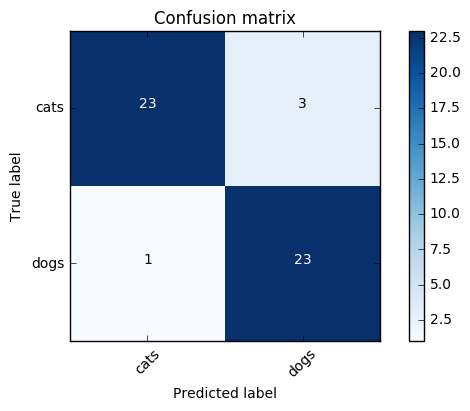

In [55]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, val_batches.class_indices)